### ETL

Una vez entendido el contexto de la problemática y teniendo bien claros los requerimientos del cliente procedemos a hacer el ETL, donde prepararemos nuestros datos para responder consultas o preparar los modelos de aprendizaje automático, y de esa manera optimizar el rendimiento de la API y el entrenamiento del modelo.


Es importante no perder el foco de nuestros endpoints objetivo:

- **def developer( desarrollador : str )**: Cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora. 
- **def userdata( User_id : str )**: Debe devolver cantidad de dinero gastado por el usuario, el porcentaje de recomendación en base a reviews.recommend y cantidad de items.
- **def UserForGenre( genero : str )**: Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista de la acumulación de horas jugadas por año de lanzamiento.
- **def best_developer_year( año : int )**: Devuelve el top 3 de desarrolladores con juegos MÁS recomendados por usuarios para el año dado. (reviews.recommend = True y comentarios positivos).
- **def developer_reviews_analysis( desarrolladora : str )**: Según el desarrollador, se devuelve un diccionario con el nombre del desarrollador como llave y una lista con la cantidad total de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento como valor positivo o negativo.


In [2]:
# IMPORTAMOS LAS LIBRERIAS NECESARIAS

import pandas as pd
import numpy as np
import ast

Cargamos nuestro dataset

In [3]:
archivo = 'australian_user_reviews.json'

data = []

with open(archivo, 'rt', encoding='utf-8') as file:
    for line in file:
        try:
            json_data = ast.literal_eval(line)
            data.append(json_data)
        except ValueError as e:
            print(f"Error en la línea: {line}")
            continue

df = pd.DataFrame(data)


In [4]:
df.head(5)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [5]:
df.shape

(25799, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


### VALORES NULOS

Revisamos cantidad de nulos que tienen las columnas y cuantas filas en blanco hay.

In [7]:
# ua vimos en el codigo anterior que no hay nulos pero sersoramos:
id_nulos = df['user_id'].isnull().sum()
url_nulos = df['user_url'].isnull().sum()
reviews_nulos = df['reviews'].isnull().sum()

print(id_nulos, url_nulos, reviews_nulos)

0 0 0


Vemos que la columna user_url no es relevante para nuestro futuro consumo de datos.

In [8]:
df1 = df.drop('user_url', axis=1)
df1.head()

,user_id,reviews
0,76561197970982479,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,"[{'funny': '3 people found this review funny',..."


### NORMALIZACION DEL DATASET (Buenas prácticas)

Realizamos las transformaciones que se consideren pertinentes con el fin de preparar los datos > mayusculas, minusculas, cammel, snake, etc

In [9]:
#cambiamos nombres de la columna

nuevos_nombres = {'reviews': 'user_review'}
df2 = df1.rename(columns=nuevos_nombres)

### TIPO DE DATO

### Revisamos el tipo de cada columna del dataset. Si es necesario realizamos conversiones de tipos de datos. 

In [10]:
print(df2.dtypes)

# Convertimos: prince>float / id>int / release_date>date

user_id        object
user_review    object
dtype: object


COLUMNA REVIEW
Vemos que tiene datos anidados , los cuales tenemos que desanidar

In [11]:
#Exploracion
print(df2['user_review'].head())

0    [{'funny': '', 'posted': 'Posted November 5, 2...
1    [{'funny': '', 'posted': 'Posted June 24, 2014...
2    [{'funny': '', 'posted': 'Posted February 3.',...
3    [{'funny': '', 'posted': 'Posted October 14, 2...
4    [{'funny': '3 people found this review funny',...
Name: user_review, dtype: object


In [12]:
#Exploracion
print(df2['user_review'].iloc[0])

[{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'}, {'funny': '', 'posted': 'Posted July 15, 2011.', 'last_edited': '', 'item_id': '22200', 'helpful': 'No ratings yet', 'recommend': True, 'review': "It's unique and worth a playthrough."}, {'funny': '', 'posted': 'Posted April 21, 2011.', 'last_edited': '', 'item_id': '43110', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]


In [13]:
# Convertir la columna 'review' en un DataFrame separado para entender un poco mas como es la morfologia de los datos
reviews_df = pd.json_normalize(df2['user_review'])
reviews_df.head()

,0,1,2,3,4,5,6,7,8,9
0,"{'funny': '', 'posted': 'Posted November 5, 20...","{'funny': '', 'posted': 'Posted July 15, 2011....","{'funny': '', 'posted': 'Posted April 21, 2011...",None,None,None,None,None,None,None
1,"{'funny': '', 'posted': 'Posted June 24, 2014....","{'funny': '', 'posted': 'Posted September 8, 2...","{'funny': '', 'posted': 'Posted November 29, 2...",None,None,None,None,None,None,None
2,"{'funny': '', 'posted': 'Posted February 3.', ...","{'funny': '', 'posted': 'Posted December 4, 20...","{'funny': '', 'posted': 'Posted November 3, 20...","{'funny': '', 'posted': 'Posted October 15, 20...","{'funny': '', 'posted': 'Posted October 15, 20...","{'funny': '', 'posted': 'Posted October 15, 20...",None,None,None,None
3,"{'funny': '', 'posted': 'Posted October 14, 20...","{'funny': '', 'posted': 'Posted July 28, 2012....","{'funny': '', 'posted': 'Posted June 2, 2012.'...","{'funny': '', 'posted': 'Posted June 29, 2014....","{'funny': '', 'posted': 'Posted November 22, 2...","{'funny': '', 'posted': 'Posted February 23, 2...",None,None,None,None
4,"{'funny': '3 people found this review funny', ...","{'funny': '1 person found this review funny', ...","{'funny': '2 people found this review funny', ...","{'funny': '', 'posted': 'Posted July 11, 2013....",None,None,None,None,None,None


Iteramos dentro de cada uno de los diccionarios, extrayendo solo tres datos: 'item_id', 'recommend', 'review'

In [14]:
lista_reviews = []
for elemento in df2['user_review']:
    for elem in elemento:
        a = [elem['item_id'], elem['recommend'], elem['review']]
        lista_reviews.append(a)

Con la lista que acabamos de armar, generamos un dataframe independiente

In [16]:
df_reviews = pd.DataFrame(lista_reviews)

In [17]:
df_reviews.head()

,0,1,2
0,1250,True,Simple yet with great replayability. In my opi...
1,22200,True,It's unique and worth a playthrough.
2,43110,True,Great atmosphere. The gunplay can be a bit chu...
3,251610,True,I know what you think when you see this title ...
4,227300,True,For a simple (it's actually not all that simpl...


In [18]:
# renombramos las columnas 

nuevos_nombres = {0:'item_id', 1:'recomend', 2:'user_review'}
df_reviews1 = df_reviews.rename(columns=nuevos_nombres)
df_reviews1

,item_id,recomend,user_review
0,1250,True,Simple yet with great replayability. In my opi...
1,22200,True,It's unique and worth a playthrough.
2,43110,True,Great atmosphere. The gunplay can be a bit chu...
3,251610,True,I know what you think when you see this title ...
4,227300,True,For a simple (it's actually not all that simpl...
...,...,...,...
59300,70,True,a must have classic from steam definitely wort...
59301,362890,True,this game is a perfect remake of the original ...
59302,273110,True,had so much fun plaing this and collecting res...
59303,730,True,:D


In [19]:
df_reviews1['item_id'] = df_reviews1['item_id'].astype(int)

In [20]:
print(df_reviews1.dtypes)

item_id         int32
recomend         bool
user_review    object
dtype: object


In [21]:
valores_unicos = df_reviews1['recomend'].unique()
valores_unicos

array([ True, False])

In [22]:
#Contamos cuantos True y cuantos False hay en recomend
valores_booleanos = df_reviews1['recomend'].value_counts()
valores_booleanos

recomend
True     52473
False     6832
Name: count, dtype: int64

### ANALISIS DE SENTIMIENTOS

Se debe crear la columna 'sentiment_analysis' aplicando análisis de sentimiento con NLP con la siguiente escala: debe tomar el valor '0' si es malo, '1' si es neutral y '2' si es positivo. 
Esta nueva columna debe reemplazar la de user_reviews.review para facilitar el trabajo de los modelos de machine learning y el análisis de datos. De no ser posible este análisis por estar ausente la reseña escrita, debe tomar el valor de 1.

In [23]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Descargamos los recursos necesarios para VADER
nltk.download('vader_lexicon')

#Creación del objeto SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pauda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
df_reviews1['sentiment_analysis'] = df_reviews1['user_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [25]:
df_reviews1['review_neg'] = df_reviews1['sentiment_analysis'].apply(lambda x: 1 if x< -0.3 else 0)
df_reviews1['review_neu'] = df_reviews1['sentiment_analysis'].apply(lambda x: 1 if -0.3<=x <= 0.3 else 0)
df_reviews1['review_pos'] = df_reviews1['sentiment_analysis'].apply(lambda x: 1 if x> 0.3 else 0)

In [26]:
df_reviews1

,item_id,recomend,user_review,sentiment_analysis,review_neg,review_neu,review_pos
0,1250,True,Simple yet with great replayability. In my opi...,0.8481,0,0,1
1,22200,True,It's unique and worth a playthrough.,0.2263,0,1,0
2,43110,True,Great atmosphere. The gunplay can be a bit chu...,0.9117,0,0,1
3,251610,True,I know what you think when you see this title ...,0.9566,0,0,1
4,227300,True,For a simple (it's actually not all that simpl...,0.9708,0,0,1
...,...,...,...,...,...,...,...
59300,70,True,a must have classic from steam definitely wort...,0.5574,0,0,1
59301,362890,True,this game is a perfect remake of the original ...,0.9786,0,0,1
59302,273110,True,had so much fun plaing this and collecting res...,0.7827,0,0,1
59303,730,True,:D,0.5106,0,0,1


In [27]:
#Eliminamos la columna user_reviews para reemplazarla por el sentimentalAnalysis asi es mas facil para el modelo que haremos
df_reviews2 = df_reviews1.drop('user_review', axis=1)
df_reviews2.head()

,item_id,recomend,sentiment_analysis,review_neg,review_neu,review_pos
0,1250,True,0.8481,0,0,1
1,22200,True,0.2263,0,1,0
2,43110,True,0.9117,0,0,1
3,251610,True,0.9566,0,0,1
4,227300,True,0.9708,0,0,1


### DISTRIBUCIÓN DE DATOS

C:\Users\pauda\AppData\Local\Temp\ipykernel_15560\3693783336.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frecuencias.index, y=frecuencias.values, palette='viridis')


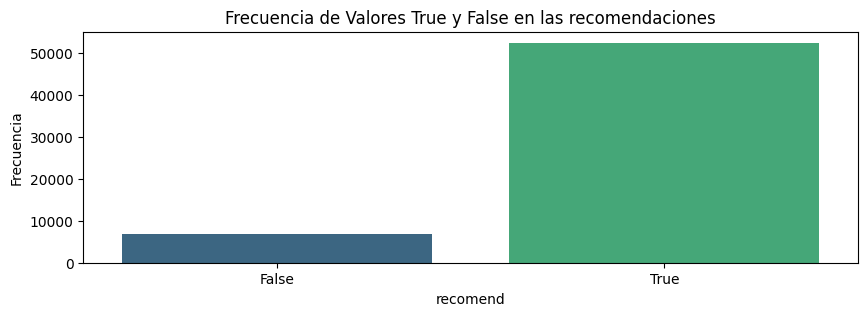

In [28]:
### Comenzamos a ya ver un poco la distribución de datos. Para ver si hay datos atipicos. Hacemos un grafico de distribucion de datos

import matplotlib.pyplot as plt
import seaborn as sns

frecuencias = df_reviews2['recomend'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 3))
sns.barplot(x=frecuencias.index, y=frecuencias.values, palette='viridis')
plt.xlabel('recomend')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Valores True y False en las recomendaciones')
plt.xticks(ticks=[0, 1], labels=['False', 'True'])  # Asegurar que los ejes estén etiquetados correctamente
plt.show()

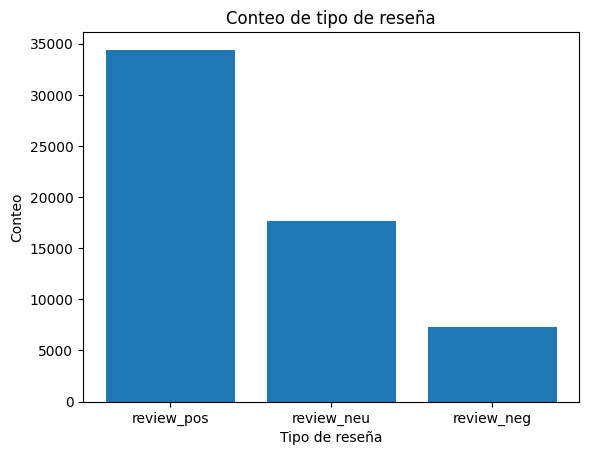

In [40]:
review_pos_count = df_reviews2['review_pos'].sum()
review_neu_count = df_reviews2['review_neu'].sum()
review_neg_count = df_reviews2['review_neg'].sum()

# Creao una lista con los conteos
counts = [review_pos_count, review_neu_count, review_neg_count]

# Creao una lista con los nombres de las columnas
labels = ['review_pos', 'review_neu', 'review_neg']

#Grafico
plt.bar(labels, counts)
plt.xlabel('Tipo de reseña')
plt.ylabel('Conteo')
plt.title('Conteo de tipo de reseña')
plt.show()

### EXPORTACIÓN DE DATOS

Exportamos la base de datos preparada en un archivo .parquet para el modelamiento

Los exportamos a csv por seguridad

In [31]:
df_reviews2.to_csv('australian_user_reviews.csv', index=False)

Exportamos Parquet con compresion Snappy 

In [ ]:
pip install pyarrow

In [34]:
df_reviews2.to_parquet('australian_user_reviews.parquet', index=False, engine='pyarrow', compression= 'snappy')